In [8]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [2]:
data_pathway = './data/ratings.csv'

data = pd.read_csv(data_pathway)

api_pathway = './data/api_key.txt'
api_key = open(api_pathway, "r").read()

In [3]:
def preprocess_data(data):
    # Drop rows with NaN entries
    processed_data = data.dropna()

    # Converts Year column from float to int
    processed_data = processed_data.astype({'Year':'int'})

    # This adds a primary key to the data
    primary_key = range(0, len(processed_data['Letterboxd URI']))
    processed_data.insert(0, column='Key', value = primary_key)

    return processed_data



# Need to rewrite this function to check for whether key exists when making a dictionary call
# Also it's possible for movies to not have IMDb entries
def extract_TMDb_data(data):
    # Propagate primary key of data as secondary key for generated dataset
    secondary_key = range(0, len(data['Letterboxd URI']))

    # We'll use the URI column to get the IMDb IDs for each movie
    URI_list = data["Letterboxd URI"]

    # Might be better to initialize these as NA to the right size, could avoid large chunks of repeated code
    # setting them to be NA if they're not present in API call
    TMDb_IDs = []

    genres_list = []
    runtime_list = []
    revenue_list = []
    budget_list = []
    original_language_list = []
    vote_average_list = []
    vote_count_list = []
    popularity_list = []
    type_list = []

    for URI in URI_list:

        page = requests.get(URI)

        soup = BeautifulSoup(page.content, "html.parser")

        results = soup.find(class_="col-17")
        sections = results.find_all("section", class_="section col-10 col-main")

        for element in sections:
            paragraphs = element.find_all("p", class_="text-link text-footer")
            for hyperlink in paragraphs:
                links = hyperlink.find_all("a", class_="micro-button track-event")
                TMDb_check = False
                for link in links:
                    if link.text == "TMDb":
                        TMDb_check = True
                        TMDb_link = link["href"]
                        ID = TMDb_link.replace('https://www.themoviedb.org', '')

                        # Changes to True if it's a movie
                        type_flag = False

                        if '/movie/' in ID:
                            type_flag = True
                            ID = ID.replace('/movie/', '')
                            TMDb_ID = ID.rstrip(ID[-1])
                            TMDb_IDs.append(TMDb_ID)
                            #print(TMDb_ID)
                        elif '/tv/' in ID:
                            ID = ID.replace('/tv/', '')
                            TMDb_ID = ID.rstrip(ID[-1])
                            TMDb_IDs.append(TMDb_ID)
                            #print(TMDb_ID)
                        else:
                            genres_list.append(pd.NA)
                            runtime_list.append(pd.NA)
                            revenue_list.append(pd.NA)
                            budget_list.append(pd.NA)
                            original_language_list.append(pd.NA)
                            vote_average_list.append(pd.NA)
                            vote_count_list.append(pd.NA)
                            popularity_list.append(pd.NA)
                            type_list.append(pd.NA)

                        
                        if type_flag == True:
                            url = "https://api.themoviedb.org/3/movie/" + TMDb_ID + "?api_key=" + api_key
                        else:
                            url = "https://api.themoviedb.org/3/tv/" + TMDb_ID + "?api_key=" + api_key

                        
                        response = requests.get(url).json()
                        # Need to implement a check that the keys are in response

                        """if 'title' in response:
                            print(response['title'])
                        elif 'original_title' in response:
                            print(response['original_title'])
                        elif 'name' in response:
                            print(response['name'])"""
                        
                        if 'genres' in response:
                            movie_genres = []
                            for items in response['genres']:
                                movie_genres.append(items['name'])
                            #print(movie_genres)
                            genres_list.append(movie_genres)
                        else:
                            # Should probably implement a scrape on the Letterboxd website to get genres as alternative
                            # since the website has genre information from URI
                            genres_list.append(pd.NA)

                        if 'runtime' in response:
                            runtime_list.append(response['runtime'])
                        else:
                            runtime_list.append(pd.NA)
                        if 'revenue' in response:
                            revenue_list.append(response['revenue'])
                        else:
                            revenue_list.append(pd.NA)
                        if 'budget' in response:
                            budget_list.append(response['budget'])
                        else:
                            budget_list.append(pd.NA)
                        if 'original_language' in response:
                            original_language_list.append(response['original_language'])
                        else:
                            original_language_list.append(pd.NA)
                        if 'vote_average' in response:
                            vote_average_list.append(response['vote_average'])
                        else:
                            vote_average_list.append(pd.NA)
                        if 'vote_count' in response:
                            vote_count_list.append(response['vote_count'])
                        else:
                            vote_count_list.append(pd.NA)
                        if 'popularity' in response:
                            popularity_list.append(response['popularity'])
                        else:
                            popularity_list.append(pd.NA)
                        if 'type' in response:
                            type_list.append(response['type'])
                        else:
                            type_list.append(pd.NA)
                if TMDb_check == False:
                    genres_list.append(pd.NA)
                    runtime_list.append(pd.NA)
                    revenue_list.append(pd.NA)
                    budget_list.append(pd.NA)
                    original_language_list.append(pd.NA)
                    vote_average_list.append(pd.NA)
                    vote_count_list.append(pd.NA)
                    popularity_list.append(pd.NA)
                    type_list.append(pd.NA)



    TMDb_data = [secondary_key, genres_list, runtime_list, revenue_list, budget_list, original_language_list, vote_average_list, vote_count_list,
                     popularity_list, type_list]

    TMDb_data = pd.DataFrame(TMDb_data).T

    column_change = ['Key', 'Genres', 'Runtime', 'Revenue', 'Budget', 'Original Language', 'Vote Average', 'Vote Count', 'Popularity', 'Type']
    column_change = dict(enumerate(column_change))
    TMDb_data = TMDb_data.rename(columns= column_change)

    return TMDb_data


In [4]:
processed_data = preprocess_data(data)
processed_data

,Key,Date,Name,Year,Letterboxd URI,Rating
0,0,2020-09-11,Knives Out,2019,https://boxd.it/jWEA,4.0
1,1,2020-09-11,Inception,2010,https://boxd.it/1skk,4.0
2,2,2020-09-11,Spider-Man: Into the Spider-Verse,2018,https://boxd.it/azpY,3.5
3,3,2020-09-11,Avengers: Infinity War,2018,https://boxd.it/9vEe,3.5
4,4,2020-09-11,Guardians of the Galaxy,2014,https://boxd.it/3VH2,3.5
...,...,...,...,...,...,...
386,385,2023-07-18,Joy Ride,2023,https://boxd.it/wEeK,3.0
387,386,2023-07-20,The Story of Stuff,2007,https://boxd.it/4JBI,4.5
388,387,2023-07-22,Barbie,2023,https://boxd.it/bCLK,3.5
389,388,2023-07-23,My Neighbor Totoro,1988,https://boxd.it/20eA,3.0


In [5]:
TMDb_data = extract_TMDb_data(processed_data)

In [10]:
TMDb_data

,Key,Genres,Runtime,Revenue,Budget,Original Language,Vote Average,Vote Count,Popularity,Type
0,0,"[Comedy, Crime, Mystery]",131,312897920,40000000,en,7.85,10995,41.253,<NA>
1,1,"[Action, Science Fiction, Adventure]",148,825532764,160000000,en,8.365,34213,88.56,<NA>
2,2,"[Action, Adventure, Animation, Science Fiction]",117,375464627,90000000,en,8.404,13739,220.377,<NA>
3,3,"[Adventure, Action, Science Fiction]",149,2052415039,300000000,en,8.259,27425,189.532,<NA>
4,4,"[Action, Science Fiction, Adventure]",121,772776600,170000000,en,7.905,26452,46.587,<NA>
...,...,...,...,...,...,...,...,...,...,...
385,385,[Comedy],95,11000000,0,en,6.607,103,51.576,<NA>
386,386,"[Animation, Documentary]",22,0,0,en,7.7,18,1.716,<NA>
387,387,"[Comedy, Adventure, Fantasy]",114,1052300070,145000000,en,7.5,2770,2247.116,<NA>
388,388,"[Fantasy, Animation, Family]",86,41000000,3700000,ja,8.07,7017,48.173,<NA>


In [11]:
data_table = pd.merge(processed_data, TMDb_data, how="inner", on="Key")

data_table

,Key,Date,Name,Year,Letterboxd URI,Rating,Genres,Runtime,Revenue,Budget,Original Language,Vote Average,Vote Count,Popularity,Type
0,0,2020-09-11,Knives Out,2019,https://boxd.it/jWEA,4.0,"[Comedy, Crime, Mystery]",131,312897920,40000000,en,7.85,10995,41.253,<NA>
1,1,2020-09-11,Inception,2010,https://boxd.it/1skk,4.0,"[Action, Science Fiction, Adventure]",148,825532764,160000000,en,8.365,34213,88.56,<NA>
2,2,2020-09-11,Spider-Man: Into the Spider-Verse,2018,https://boxd.it/azpY,3.5,"[Action, Adventure, Animation, Science Fiction]",117,375464627,90000000,en,8.404,13739,220.377,<NA>
3,3,2020-09-11,Avengers: Infinity War,2018,https://boxd.it/9vEe,3.5,"[Adventure, Action, Science Fiction]",149,2052415039,300000000,en,8.259,27425,189.532,<NA>
4,4,2020-09-11,Guardians of the Galaxy,2014,https://boxd.it/3VH2,3.5,"[Action, Science Fiction, Adventure]",121,772776600,170000000,en,7.905,26452,46.587,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,385,2023-07-18,Joy Ride,2023,https://boxd.it/wEeK,3.0,[Comedy],95,11000000,0,en,6.607,103,51.576,<NA>
386,386,2023-07-20,The Story of Stuff,2007,https://boxd.it/4JBI,4.5,"[Animation, Documentary]",22,0,0,en,7.7,18,1.716,<NA>
387,387,2023-07-22,Barbie,2023,https://boxd.it/bCLK,3.5,"[Comedy, Adventure, Fantasy]",114,1052300070,145000000,en,7.5,2770,2247.116,<NA>
388,388,2023-07-23,My Neighbor Totoro,1988,https://boxd.it/20eA,3.0,"[Fantasy, Animation, Family]",86,41000000,3700000,ja,8.07,7017,48.173,<NA>


In [12]:
# Figure out EDA


def top_N_genres(data, treshold = 5):
    genres_list = data["Genres"].to_numpy().flatten().tolist()
    null_check = data["Genres"].isnull().to_numpy().tolist()
    
    total_genre_list = []
    for i in range(len(genres_list)):
        if null_check[i]:
            total_genre_list.append("NA")
        else:
            genres = genres_list[i]
            for genre in genres:
                total_genre_list.append(genre)

    genre_categories = np.unique(total_genre_list)
    counts = pd.DataFrame(np.zeros(len(genre_categories))).T
    counts = counts.rename(columns= dict(enumerate(genre_categories)))

    for genre in total_genre_list:
        for category in genre_categories:
            if genre == category:
                counts[category] += 1

    counts_column = dict(enumerate(["Counts"]))
    counts = counts.T
    counts = counts.rename(columns=counts_column)

    counts = counts.sort_values(by = ['Counts'], ascending=False)

    return counts.head(treshold)

# Have a runtime histogram

# Summary statistics on ratings
#def ratings_statistics(data):
    

# Look at distribution on language (convert to factors and check)

<Axes: >

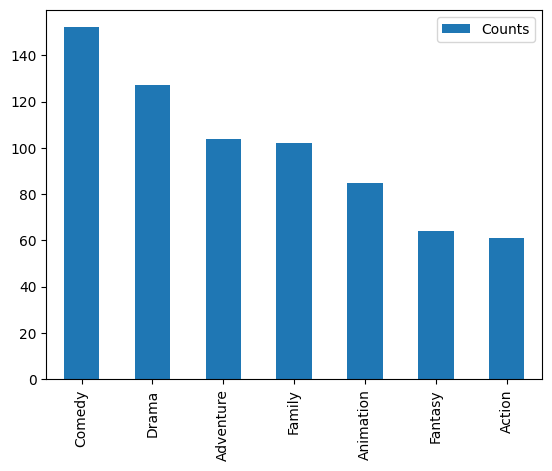

In [13]:
top_genres = top_N_genres(data_table, treshold = 7)
top_genres.plot.bar()



In [ ]:
# Also w.r.t scripts, recent movies will probably not have scripts out
# Also non-english scripts? Maybe subtitles